In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler 

#clustering model library
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#from sklearn_extra.cluster import KMedoids
from kmodes.kmodes import KModes
from yellowbrick.cluster import KElbowVisualizer , SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn import metrics
import math
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def data_scan(dataframe, columns):
    pd.options.display.float_format = '{:,.4f}'.format
    data_types=[]
    unique_values=[]
    total_unique=[]
    total_null=[]
    percentage_null=[]
    total_duplicates=[]
    total_missing_count=[]
    percentage_missing_values=[]
    for col in columns:
        # Data Type
        col_type = dataframe[col].dtype
        data_types.append(col_type)
        # Unique Values
        unique_col_values = np.array(dataframe[col].unique())
        unique_values.append(unique_col_values)
        # Total unique values
        total_unique_values= dataframe[col].nunique()
        total_unique.append(total_unique_values)
        # Total duplicates
        total_col_duplicates = dataframe[col].duplicated().sum()
        total_duplicates.append(total_col_duplicates)
        # Total Null
        total_col_null= dataframe[col].isnull().sum()
        total_null.append(total_col_null)
        # % of Null values
        per_col_null = 100*(total_col_null/len(dataframe[col]))
        percentage_null.append(per_col_null)
        # Missing Values Count
        row_count = dataframe.shape[0]
        m_count = dataframe[dataframe[col] == -1][col].count()
        total_missing_count.append(m_count)
        # Percentage missing values
        percentage_missing=round(100*(m_count/row_count), 3)
        percentage_missing_values.append(percentage_missing)
        
    
    # Create data frame
    data = {
        'Feature Name':columns,
        'Data Type': data_types,
        'Unique Values': unique_values,
        'Total Unique Values':total_unique,
        'Total Duplicates':total_duplicates,
        'Total Missing Values': total_missing_count,
        'Percentage Missing Values': percentage_missing_values, 
        'Total Null': total_null,
        'Percentage of Null Values': percentage_null,    
    }
    df= pd.DataFrame(data)
    
    return df

In [3]:
# File path

filename="Data/marketing_campaign.csv"

## 1. Data Description

The dataset contains 29 variables and 2240 observations about different customers.<br>

#### Demographics<br>
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

####  Products<br>
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

#### Promotion <br>
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

#### Place<br>
- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

In [4]:
# Read the file 
data = pd.read_csv(filename,sep="\t")

# Visualize the data
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2. EDA & Data Cleaning

### 2.1 Initial EDA

In [5]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# Run the function DataScan to obtain more info about the data
data_scan(data, data.columns)

,Feature Name,Data Type,Unique Values,Total Unique Values,Total Duplicates,Total Missing Values,Percentage Missing Values,Total Null,Percentage of Null Values
0,ID,int64,"[5524, 2174, 4141, 6182, 5324, 7446, 965, 6177...",2240,0,0,0.0000,0,0.0000
1,Year_Birth,int64,"[1957, 1954, 1965, 1984, 1981, 1967, 1971, 198...",59,2181,0,0.0000,0,0.0000
2,Education,object,"[Graduation, PhD, Master, Basic, 2n Cycle]",5,2235,0,0.0000,0,0.0000
3,Marital_Status,object,"[Single, Together, Married, Divorced, Widow, A...",8,2232,0,0.0000,0,0.0000
4,Income,float64,"[58138.0, 46344.0, 71613.0, 26646.0, 58293.0, ...",1974,265,0,0.0000,24,1.0714
5,Kidhome,int64,"[0, 1, 2]",3,2237,0,0.0000,0,0.0000
6,Teenhome,int64,"[0, 1, 2]",3,2237,0,0.0000,0,0.0000
7,Dt_Customer,object,"[04-09-2012, 08-03-2014, 21-08-2013, 10-02-201...",663,1577,0,0.0000,0,0.0000
8,Recency,int64,"[58, 38, 26, 94, 16, 34, 32, 19, 68, 11, 59, 8...",100,2140,0,0.0000,0,0.0000
9,MntWines,int64,"[635, 11, 426, 173, 520, 235, 76, 14, 28, 5, 6...",776,1464,0,0.0000,0,0.0000


**Annotations:**<br>
    - Income variable has missing values. 1.07% of the values are missing<br>
    - There are two categorical variables<br>
    - Dt_Customer variable is not set as DateTime<br>
    - Education variable contains several variables that could be reduce<br>
    - Marital_Status variable contains several variables that could be reduce<br>
    - The variables Kidhome and Teenhome could be concatenanted since both refer to dependant individuals<br>
    - Variables to drop: Recency, Complain, Z_CostContact, Z_Revenue, Response

In [7]:
# Basic statistics for raw data

data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,"2,240.0000","2,240.0000","2,216.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000",...,"2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000","2,240.0000"
mean,"5,592.1598","1,968.8058","52,247.2514",0.4442,0.5062,49.1094,303.9357,26.3022,166.9500,37.5254,...,5.3165,0.0728,0.0746,0.0728,0.0643,0.0134,0.0094,3.0000,11.0000,0.1491
std,"3,246.6622",11.9841,"25,173.0767",0.5384,0.5445,28.9625,336.5974,39.7734,225.7154,54.6290,...,2.4266,0.2598,0.2627,0.2598,0.2453,0.1150,0.0964,0.0000,0.0000,0.3563
min,0.0000,"1,893.0000","1,730.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,11.0000,0.0000
25%,"2,828.2500","1,959.0000","35,303.0000",0.0000,0.0000,24.0000,23.7500,1.0000,16.0000,3.0000,...,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,11.0000,0.0000
50%,"5,458.5000","1,970.0000","51,381.5000",0.0000,0.0000,49.0000,173.5000,8.0000,67.0000,12.0000,...,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,11.0000,0.0000
75%,"8,427.7500","1,977.0000","68,522.0000",1.0000,1.0000,74.0000,504.2500,33.0000,232.0000,50.0000,...,7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,11.0000,0.0000
max,"11,191.0000","1,996.0000","666,666.0000",2.0000,2.0000,99.0000,"1,493.0000",199.0000,"1,725.0000",259.0000,...,20.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,3.0000,11.0000,1.0000


After the inital EDA findigs, these are the steps to follow:

1. Remove NA values
    
2. Category reduction
- Reduce the categories for Marital_Status from 8 to 2. Relationship: Married, Together. Single: Absurd, Widow, YOLO, Divorced, Single
- Reduce the categories from Education from 5 to 3. Undergraduate: Basic, 2n Cycle. Graduate: Graduation. Postgraduate: Master, Phd

3. New Variables
- Total_spend = Add the total spent on each food category
- Dependants = Add the Kidhome and Teenhome variables
- Total_accepted= Add the total accepted variables
- Total_purchase = Add the total purchase for each method
- Age = Create the variable Age using birth year

4. Remove Variables
- Z_CostContact
- Z_Revenue


### 2.2 Remove Missing Values

In [8]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))


The total number of data-points after removing the rows with missing values are: 2216


### 2.3 Categories reduction

In [9]:
# Visualize "Education" variable
data['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [10]:
#Update values
data['Education']=data['Education'].replace(['Graduation', 'PhD','Master'],'Graduate')
data['Education']=data['Education'].replace(['Basic', '2n Cycle'],'Undergraduate')

# Review new categories
data['Education'].value_counts()

Graduate         1962
Undergraduate     254
Name: Education, dtype: int64

In [11]:
# Visualize "Marital Status" variable
data['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [12]:
#Update values
data['Marital_Status']=data['Marital_Status'].replace(['Married', 'Together'],'Relationship')
data['Marital_Status']=data['Marital_Status'].replace(['Single', 'Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

# Review new categories
data['Marital_Status'].value_counts()

Relationship    1430
Single           786
Name: Marital_Status, dtype: int64

### 2.3 New Variables

In [13]:
# Create features list based on the variable grouping for easy accesing

# Products features

all_features = data.columns
prod_features = []
for feature in all_features:
    if feature.startswith('Mnt'):
        prod_features.append(feature)
    else:
        continue

In [14]:
# Create Total_Spend columns
data['Total_Spend']=data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

In [15]:
# Create Dependents column
data['Dependents']=data["Kidhome"]+data["Teenhome"]

In [16]:
# Create Total_Accepted column
data['Total_Accepted']=data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']

In [17]:
# Create Total_Purchases column
data['Total_Purchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumDealsPurchases']

In [18]:
# Create Age  column
data['Age'] = 2022 - data['Year_Birth']

### 3.3 Remove columns

In [19]:
# Create a copy of the data frame with only the columns of interest
df = data.copy()
#col_del =['ID', 'Year_Birth', 'Kidhome','Teenhome', 'Dt_Customer', 'Recency',  'Z_CostContact', 'Z_Revenue', 'Response']
#df.drop(columns=col_del,axis=1, inplace=True)

In [20]:
df.shape

(2216, 34)

### 3.4 Advanced EDA

In [21]:
# Create a function to plot the variables from the different groups

def bar_charts(cols, title):
    number_of_cols=2
    number_of_rows= math.ceil(len(cols)/2)
    
    # Create the figure
    fig = plt.figure(figsize=(20,8 * number_of_rows)) 
    fig.suptitle(title, fontsize=20,  y=.95)
    
    # Loop to plot each cathegory 
    for index, column in enumerate(cols, 1):
        
        #create the subplot
        ax= fig.add_subplot(number_of_rows, number_of_cols, index)
        ax.legend= np.array(df[column].unique())
        plot = df[column].value_counts().plot(kind='bar', color="royalblue")
        plot.set_title(column, fontsize=14, loc='center')
        plot.tick_params(rotation='auto')
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            plot.spines[spine_name].set_visible(False)


        
    

#### 3.4.1 Demographic Features

In [22]:
# Create a list with the demographic features for easy accesing
cat_demographics_features =['Education', 'Marital_Status','Dependents', 'Complain']


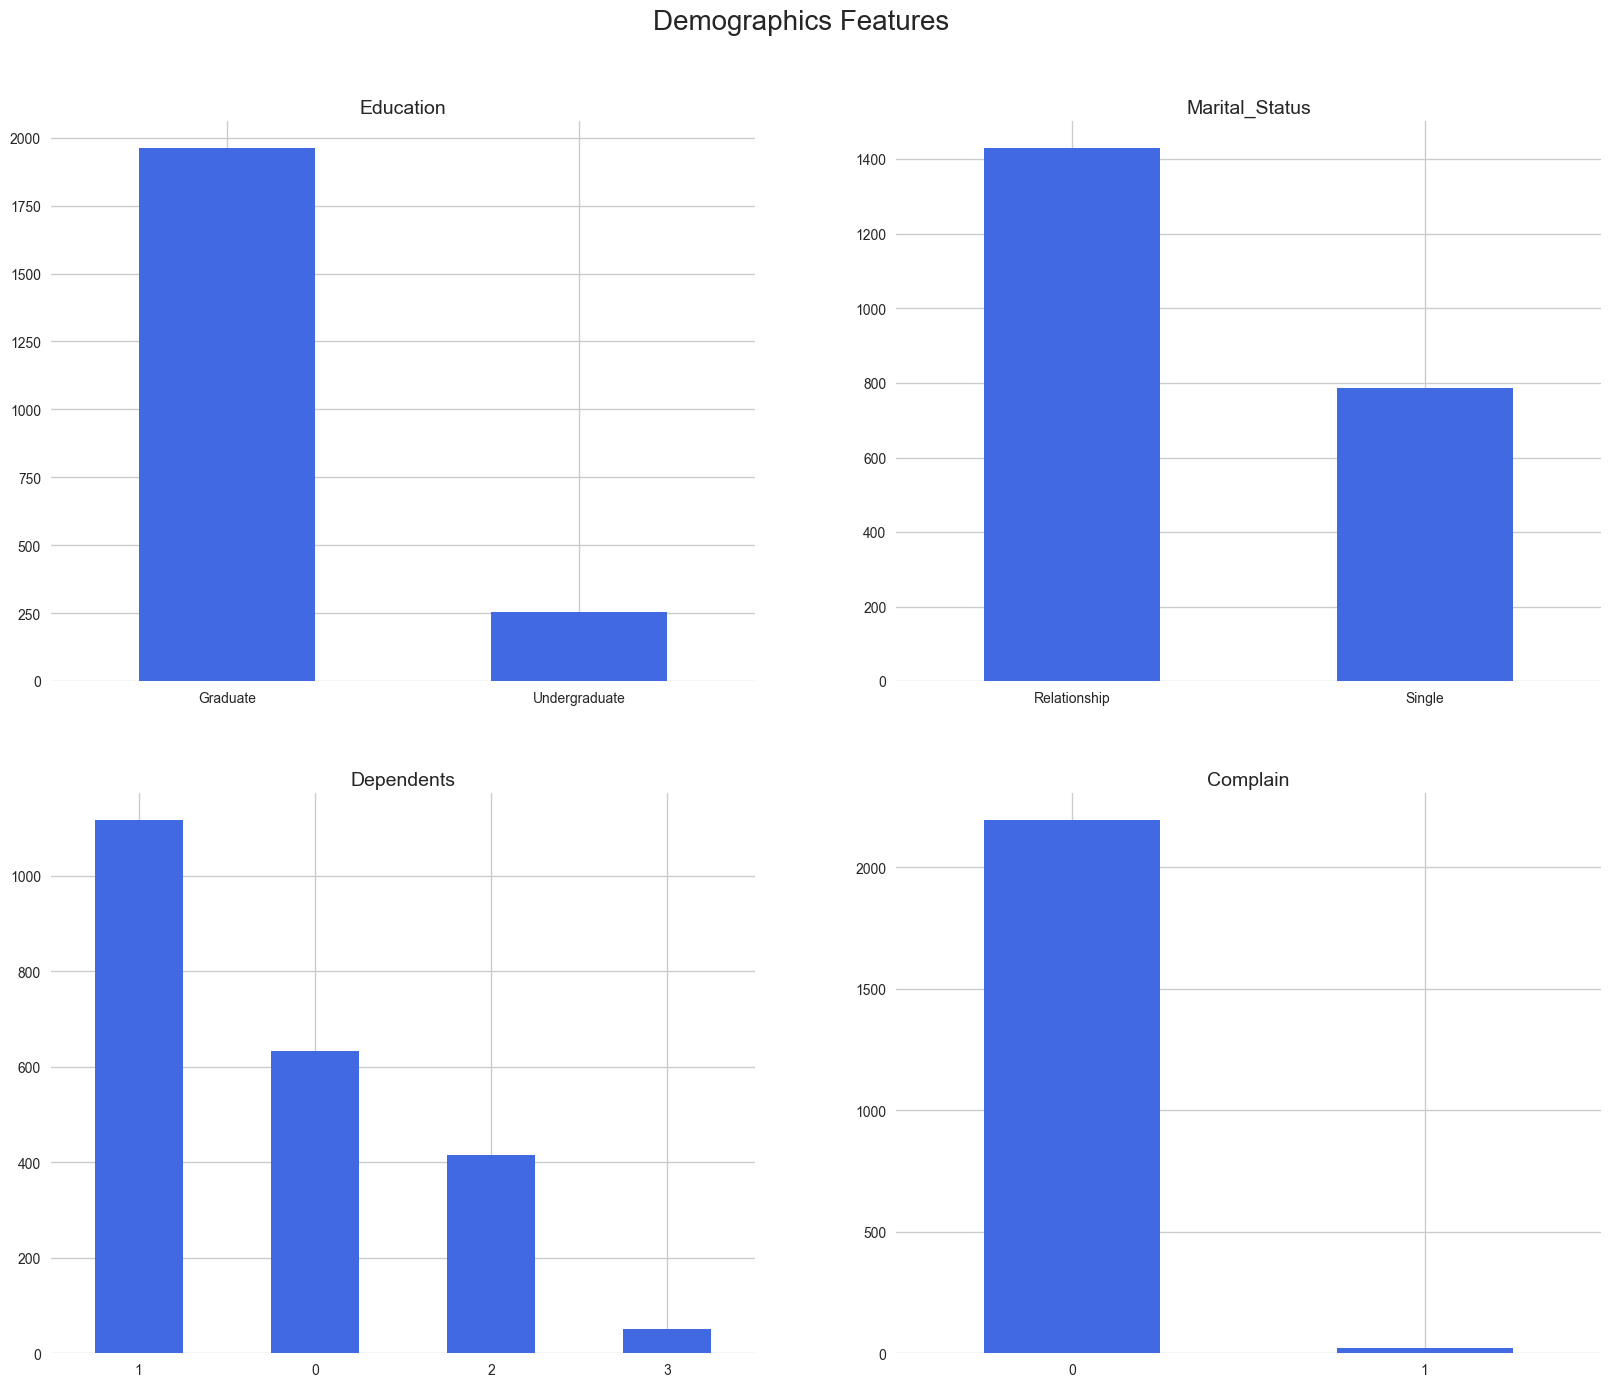

In [23]:
bar_charts(cat_demographics_features, 'Demographics Features')

#### Anotations:


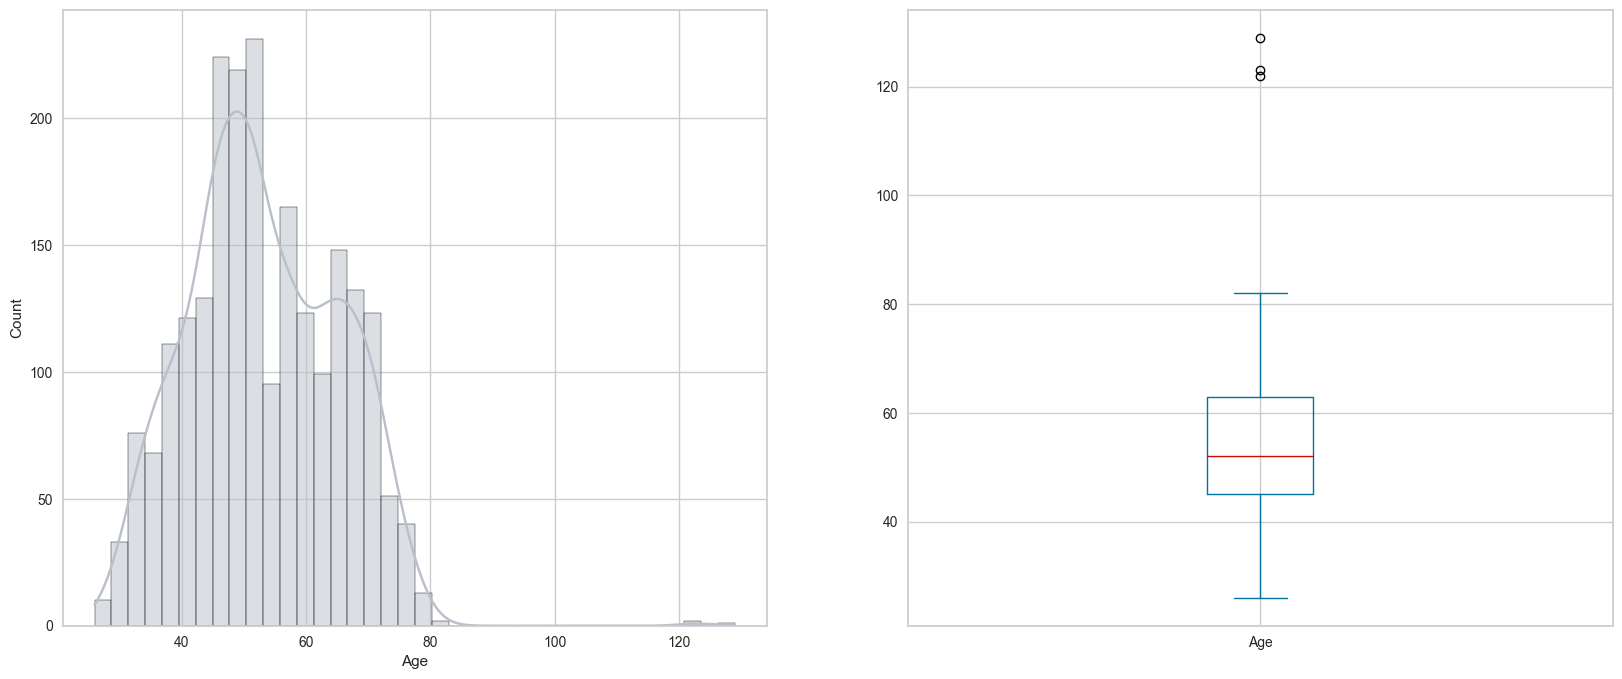

In [24]:
# Age
plt.subplot(1,2,1)
sns.histplot(data=df, x="Age", kde=True,color='#B9C0C9')
plt.subplot(1,2,2)
df["Age"].plot.box(figsize=(20,8))
plt.show()

#### Anotations:
- There are aoutliers in the Age variable. Thes outliers could be dropped. They represent people older than 100 years.

<AxesSubplot: >

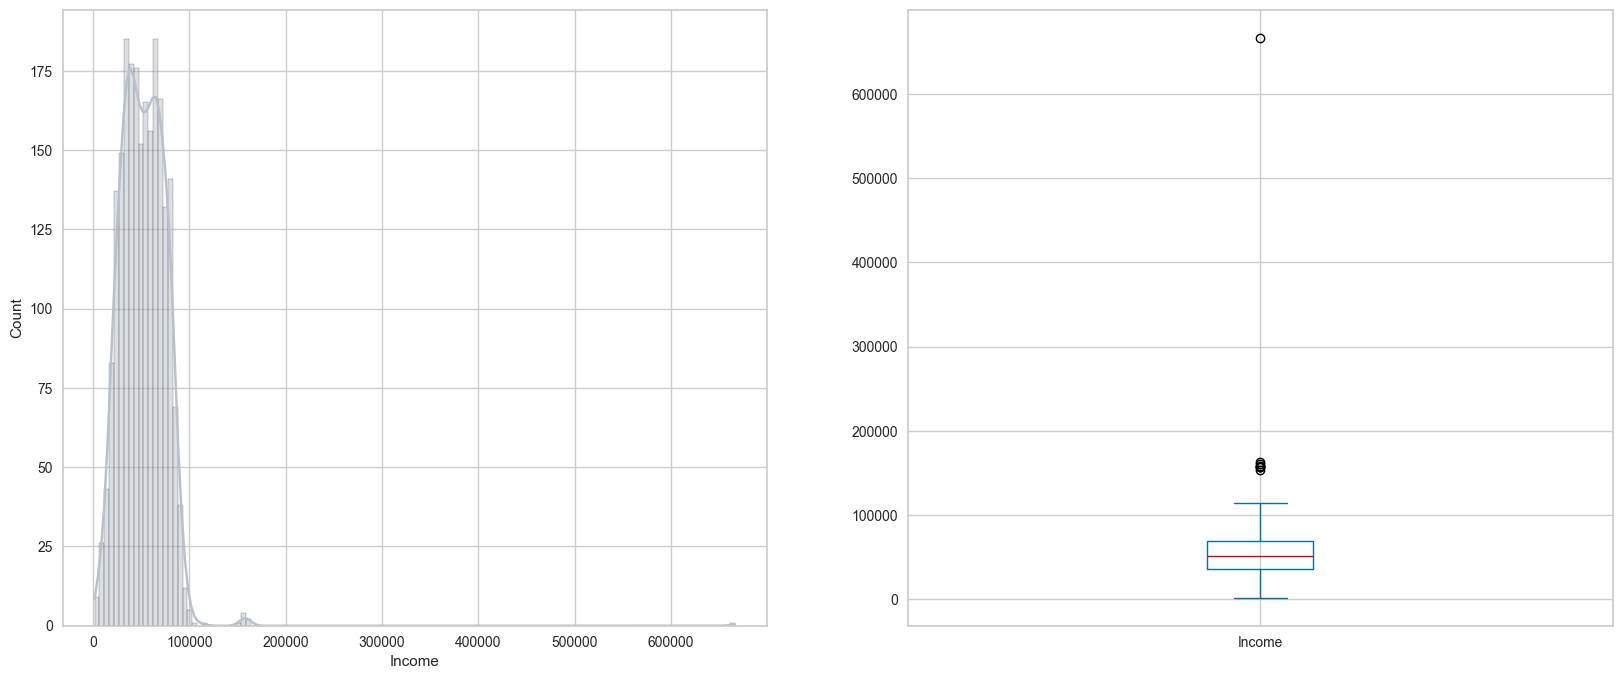

In [25]:
# Income
plt.subplot(1,2,1)
sns.histplot(data=df, x="Income", kde=True, color='#B9C0C9')
plt.subplot(1,2,2)
df["Income"].plot.box(figsize=(20,8))

#### Anotations:

- The "Inconme" variables includes outliers that needs to be removed. 

In [26]:
#Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]

#### 3.4.2 Products Features

In [27]:
# Create a list with the demographic features for easy accesing
products_features =['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']

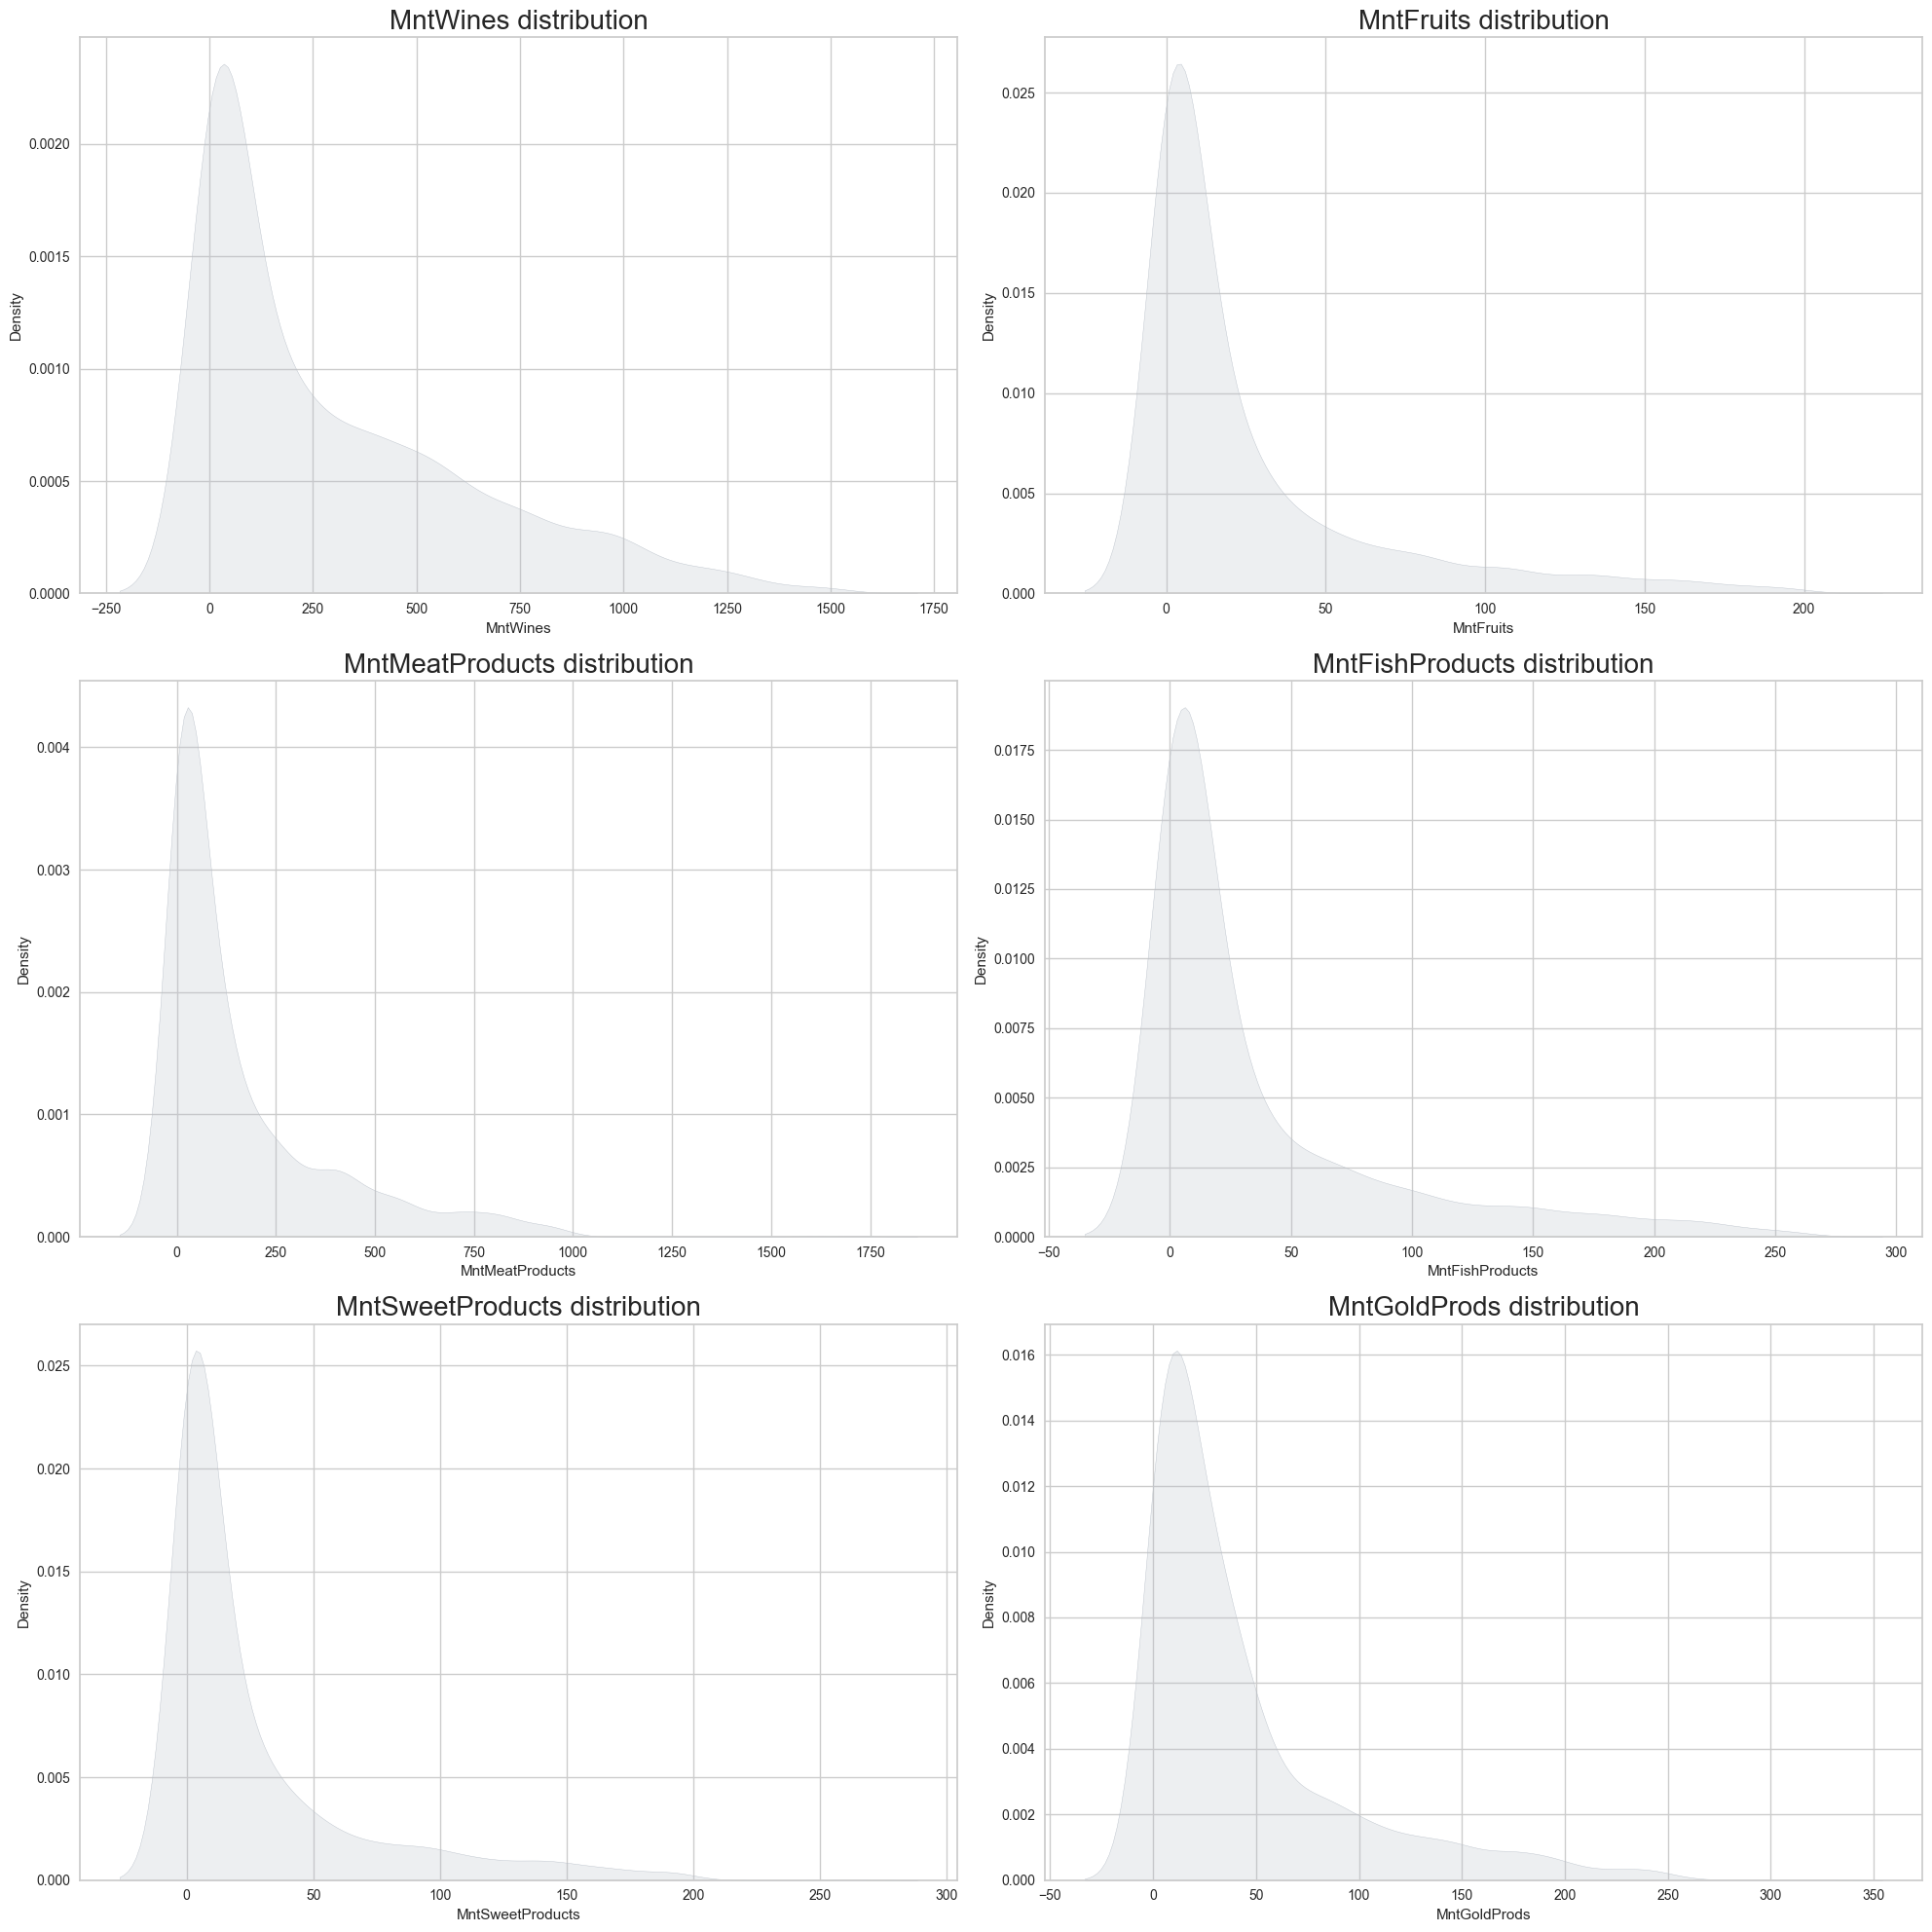

In [28]:
# Create the density plot for each variable in the Products Features group
plt.figure(figsize=(20,20))
for i,feature in enumerate(products_features):    
    plt.subplot(3,2,i + 1)    
    sns.kdeplot(data=df, x=feature, color='#B9C0C9', fill=True)
    plt.title(f'{feature} distribution',fontsize = 20)
    plt.tight_layout()

<AxesSubplot: >

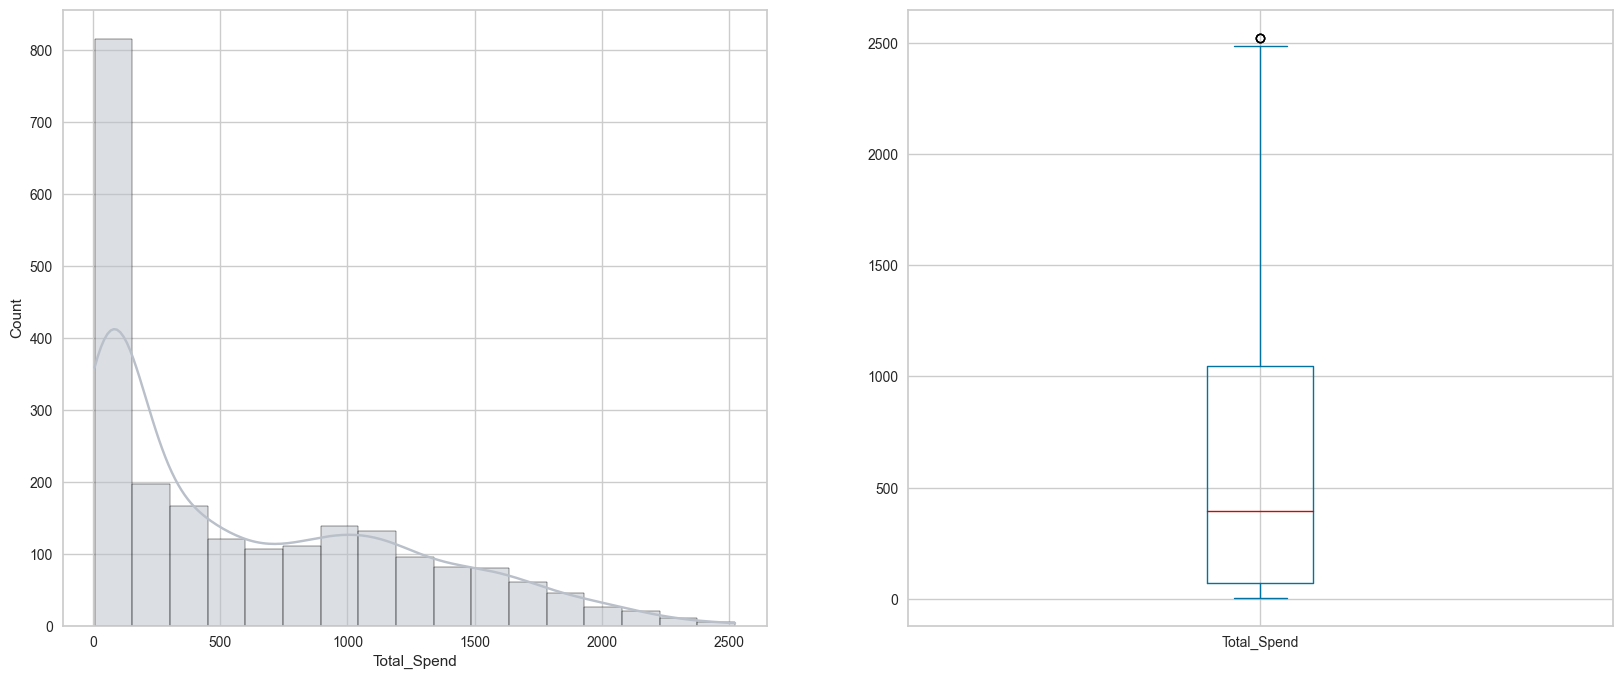

In [29]:
#r Total_Spend
plt.subplot(1,2,1)
sns.histplot(data=df, x="Total_Spend", kde=True, color='#B9C0C9')
plt.subplot(1,2,2)
data["Total_Spend"].plot.box(figsize=(20,8))

#### 3.4.2 Promotion Features

In [30]:
promotion_features=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2','Total_Accepted']

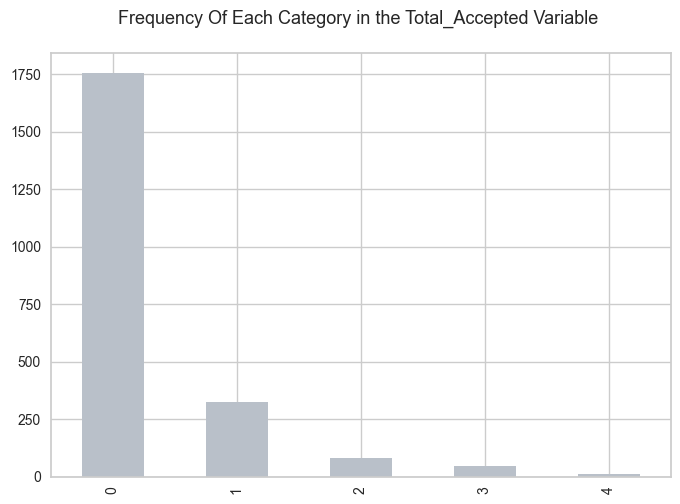

<Figure size 1600x1200 with 0 Axes>

In [31]:
# 
df['Total_Accepted'].value_counts().plot(kind='bar',color = '#B9C0C9')
plt.title("Frequency Of Each Category in the Total_Accepted Variable \n", fontsize=13)
plt.figure(figsize=(16,12))
plt.show()

#### Anotations:

- Most of people don't accept offers

<AxesSubplot: >

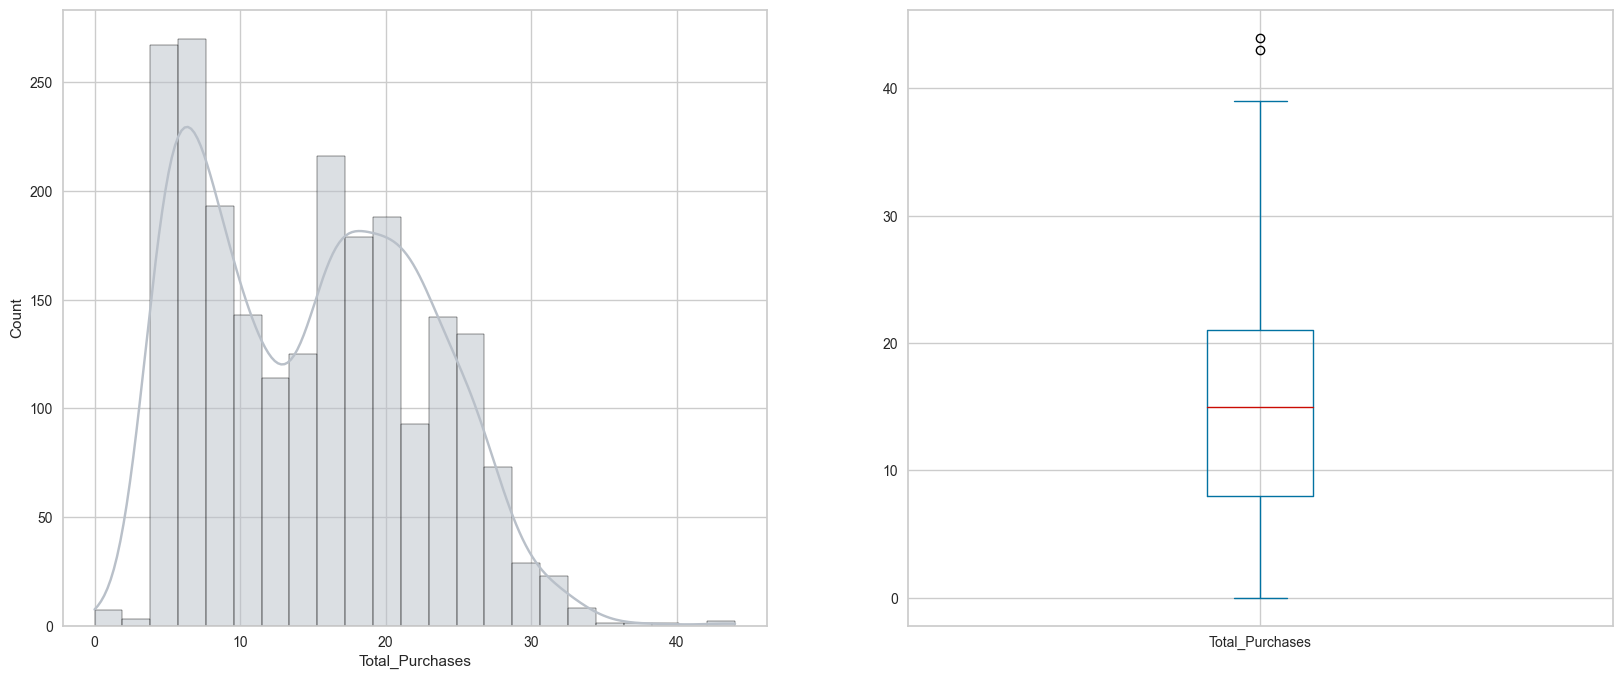

In [32]:
# Total_Purchases
plt.subplot(1,2,1)
sns.histplot(data=df, x="Total_Purchases", kde=True, color='#B9C0C9')
plt.subplot(1,2,2)
data["Total_Purchases"].plot.box(figsize=(20,8))

#### 3.4.2 Place Features

In [33]:
place_features = ['NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']

Text(0.5, 1.0, 'Total Purchases by Place')

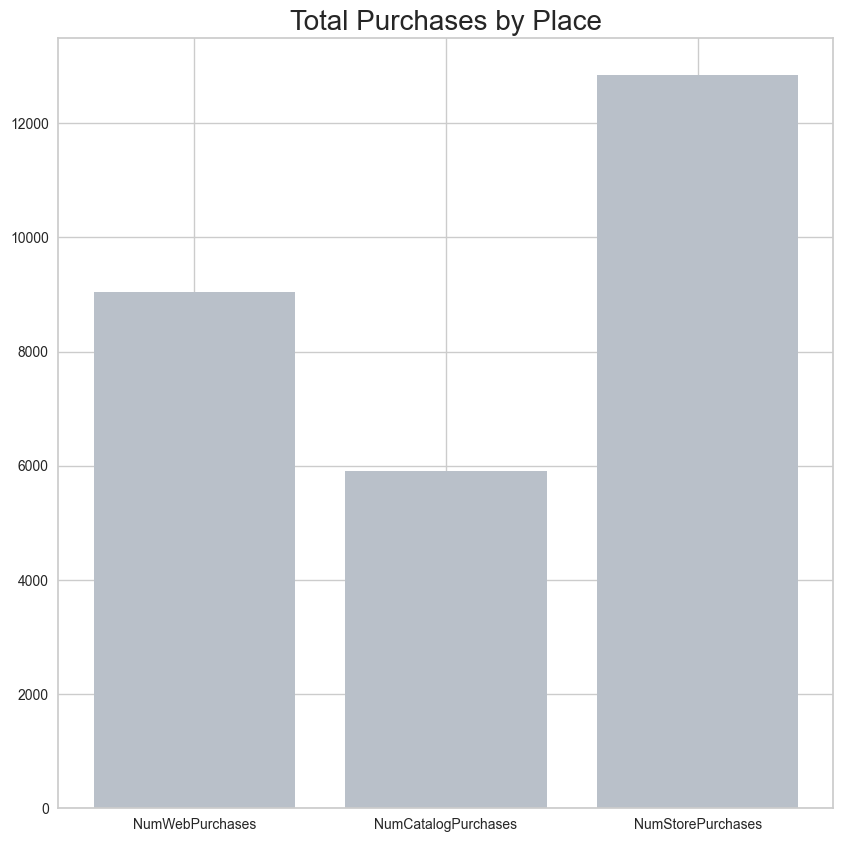

In [34]:
place_total=[]
for place in place_features:
    total= df[place].sum()
    place_total.append(total)
    
plt.figure(figsize=(10,10))    
plt.bar(place_features, place_total,  color='#B9C0C9')
plt.title("Total Purchases by Place", fontsize = 20)


#### Anotations:

In-person shopping is the most favorite shopping method

### Binary variables

The purpose of this analysis is to idenfity important caracteristics on the population that impact the spend. The variables selected for the binary analysis are:<br>
    - Education <br>
    - Marital_Status<br>
    - Income<br>
    - Dependents<br>
    - Total Accepted<br>
    - Age<br>

#### 3.4.5 Total Spend Vs Education


In [35]:
def binary_plot(x, y):
    pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
    plt.figure(figsize=(4,4))
    plt.title(("How {} impacts on {}?").format(x,y) ,fontsize=12)
    ax = sns.barplot(x=x, y=y, data=data, palette=pal)   

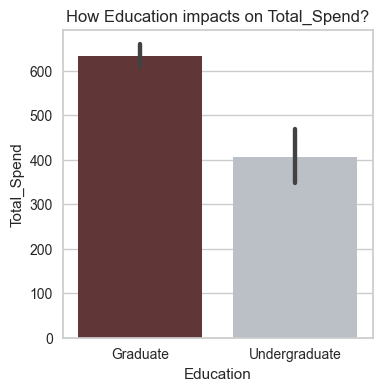

In [36]:
binary_plot("Education", "Total_Spend")

#### Anotations:
- People with a graduate degree spend around 33.00% more than people with an undergraduate degree

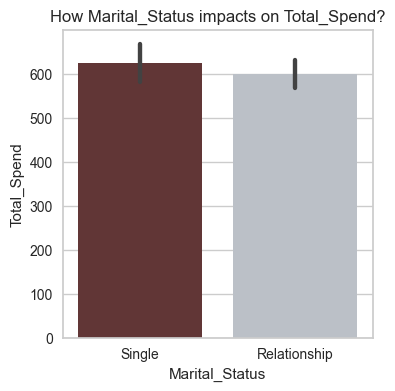

In [37]:
binary_plot("Marital_Status", "Total_Spend")

#### Anotations:
- The marital status doesn't look to highly impact on how much people spend

Text(0, 0.5, 'Total Spend')

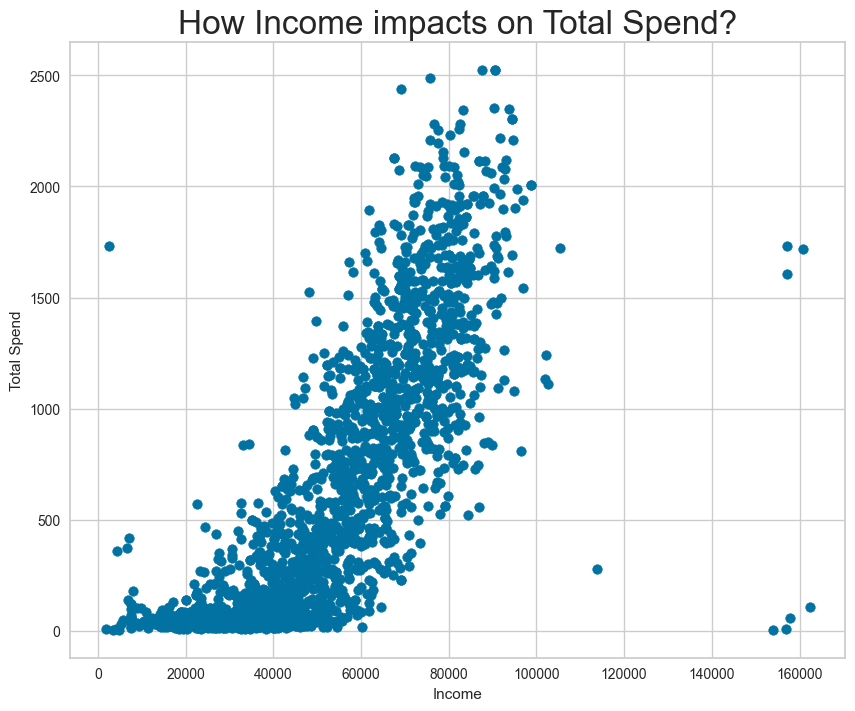

In [38]:
plt.figure(figsize=(10,8))
plt.title(("How Income impacts on Total Spend?") ,fontsize=24)
plt.scatter(df["Income"], df["Total_Spend"])
plt.xlabel("Income")
plt.ylabel("Total Spend")

#### Anotations:
- The marital status doesn't have a hihg impact on how much people spend

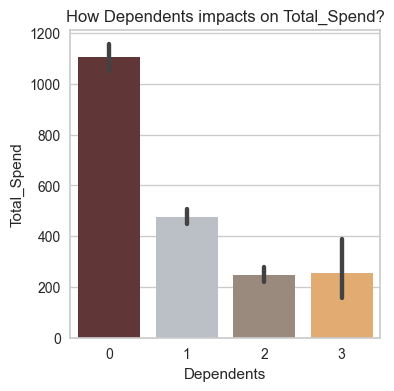

In [39]:
# Dependets 

binary_plot("Dependents", "Total_Spend")

#### Anotations:
- People without dependents spend more money

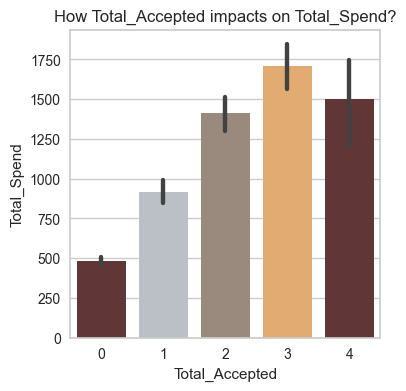

In [40]:
binary_plot("Total_Accepted", "Total_Spend")

#### Anotations:
- The number of offers accepted looks to have a positive relationship with the total spend. However, after three offers the customer tends to be more conservative

In [41]:
# Create bins to plot the age

df["Age_bins"]= pd.qcut(df['Age'], q=4, precision=0)

In [42]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age,Age_bins
0,5524,1957,Graduate,Single,"58,138.0000",0,0,04-09-2012,58,635,...,0,3,11,1,1617,0,0,25,65,"(63.0, 82.0]"
1,2174,1954,Graduate,Single,"46,344.0000",1,1,08-03-2014,38,11,...,0,3,11,0,27,2,0,6,68,"(63.0, 82.0]"
2,4141,1965,Graduate,Relationship,"71,613.0000",0,0,21-08-2013,26,426,...,0,3,11,0,776,0,0,21,57,"(52.0, 63.0]"
3,6182,1984,Graduate,Relationship,"26,646.0000",1,0,10-02-2014,26,11,...,0,3,11,0,53,1,0,8,38,"(25.0, 45.0]"
4,5324,1981,Graduate,Relationship,"58,293.0000",1,0,19-01-2014,94,173,...,0,3,11,0,422,1,0,19,41,"(25.0, 45.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduate,Relationship,"61,223.0000",0,1,13-06-2013,46,709,...,0,3,11,0,1341,1,0,18,55,"(52.0, 63.0]"
2236,4001,1946,Graduate,Relationship,"64,014.0000",2,1,10-06-2014,56,406,...,0,3,11,0,444,3,1,22,76,"(63.0, 82.0]"
2237,7270,1981,Graduate,Single,"56,981.0000",0,0,25-01-2014,91,908,...,0,3,11,0,1241,0,1,19,41,"(25.0, 45.0]"
2238,8235,1956,Graduate,Relationship,"69,245.0000",0,1,24-01-2014,8,428,...,0,3,11,0,843,1,0,23,66,"(63.0, 82.0]"


In [43]:
# Dependen

#binary_plot("Age_bins", "Total_Spend")

#### Anotations:
-People in the range of age from 63 to 82 years old tend to spend more money 

In [44]:
# Data for modeling

col_del = ['ID', 'Year_Birth',  'Kidhome','Teenhome', 'Dt_Customer',
           'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Z_CostContact', 'Z_Revenue', 'Complain', 'Response', 'Age_bins']

# Delete columns 
df.drop(columns=col_del,axis=1, inplace=True)

# Visualize data
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
0,Graduate,Single,"58,138.0000",58,635,88,546,172,88,88,3,8,10,4,7,1617,0,0,25,65
1,Graduate,Single,"46,344.0000",38,11,1,6,2,1,6,2,1,1,2,5,27,2,0,6,68
2,Graduate,Relationship,"71,613.0000",26,426,49,127,111,21,42,1,8,2,10,4,776,0,0,21,57
3,Graduate,Relationship,"26,646.0000",26,11,4,20,10,3,5,2,2,0,4,6,53,1,0,8,38
4,Graduate,Relationship,"58,293.0000",94,173,43,118,46,27,15,5,5,3,6,5,422,1,0,19,41


In [45]:
# Basic statistic

df.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
count,"2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000","2,212.0000"
mean,"51,958.8106",49.0194,305.2875,26.3296,167.0298,37.6487,27.0466,43.9259,2.3246,4.0882,2.6722,5.8065,5.3214,607.2681,0.9476,0.2984,14.8915,53.0863
std,"21,527.2788",28.9431,337.3229,39.7441,224.2545,54.7720,41.0910,51.7070,1.9245,2.7422,2.9275,3.2509,2.4256,602.5134,0.7495,0.6796,7.6716,11.7016
min,"1,730.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.0000,26.0000
25%,"35,233.5000",24.0000,24.0000,2.0000,16.0000,3.0000,1.0000,9.0000,1.0000,2.0000,0.0000,3.0000,3.0000,69.0000,0.0000,0.0000,8.0000,45.0000
50%,"51,371.0000",49.0000,175.5000,8.0000,68.0000,12.0000,8.0000,24.5000,2.0000,4.0000,2.0000,5.0000,6.0000,397.0000,1.0000,0.0000,15.0000,52.0000
75%,"68,487.0000",74.0000,505.0000,33.0000,232.2500,50.0000,33.0000,56.0000,3.0000,6.0000,4.0000,8.0000,7.0000,"1,048.0000",1.0000,0.0000,21.0000,63.0000
max,"162,397.0000",99.0000,"1,493.0000",199.0000,"1,725.0000",259.0000,262.0000,321.0000,15.0000,27.0000,28.0000,13.0000,20.0000,"2,525.0000",3.0000,4.0000,44.0000,82.0000


In [46]:
df.corr()['Dependents']

/var/folders/13/lwm1vcb93318m742brcmvqvm0000gn/T/ipykernel_84716/2459308579.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Dependents']


Income                -0.3435
Recency                0.0181
MntWines              -0.3534
MntFruits             -0.3952
MntMeatProducts       -0.5042
MntFishProducts       -0.4275
MntSweetProducts      -0.3892
MntGoldProds          -0.2678
NumDealsPurchases      0.4361
NumWebPurchases       -0.1489
NumCatalogPurchases   -0.4432
NumStorePurchases     -0.3238
NumWebVisitsMonth      0.4156
Total_Spend           -0.4999
Dependents             1.0000
Total_Accepted        -0.2454
Total_Purchases       -0.2502
Age                    0.0927
Name: Dependents, dtype: float64

## 4. Data Preprocessing

The following steps are applied to preprocess the data:<br>

- Label encoding the categorical features<br>
- Scaling the features using the standard scaler<br>
- Creating a subset dataframe for dimensionality reduction<br>

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Recency              2212 non-null   int64  
 4   MntWines             2212 non-null   int64  
 5   MntFruits            2212 non-null   int64  
 6   MntMeatProducts      2212 non-null   int64  
 7   MntFishProducts      2212 non-null   int64  
 8   MntSweetProducts     2212 non-null   int64  
 9   MntGoldProds         2212 non-null   int64  
 10  NumDealsPurchases    2212 non-null   int64  
 11  NumWebPurchases      2212 non-null   int64  
 12  NumCatalogPurchases  2212 non-null   int64  
 13  NumStorePurchases    2212 non-null   int64  
 14  NumWebVisitsMonth    2212 non-null   int64  
 15  Total_Spend          2212 non-null   i

### 4.1 Label Encoding 

In [48]:
cat_features = ["Education", "Marital_Status"]

# creating instance of labelencoder
labelencoder = LabelEncoder()

for variable in cat_features:
    df[variable]= labelencoder.fit_transform(df[variable])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Marital_Status       2212 non-null   int64  
 2   Income               2212 non-null   float64
 3   Recency              2212 non-null   int64  
 4   MntWines             2212 non-null   int64  
 5   MntFruits            2212 non-null   int64  
 6   MntMeatProducts      2212 non-null   int64  
 7   MntFishProducts      2212 non-null   int64  
 8   MntSweetProducts     2212 non-null   int64  
 9   MntGoldProds         2212 non-null   int64  
 10  NumDealsPurchases    2212 non-null   int64  
 11  NumWebPurchases      2212 non-null   int64  
 12  NumCatalogPurchases  2212 non-null   int64  
 13  NumStorePurchases    2212 non-null   int64  
 14  NumWebVisitsMonth    2212 non-null   int64  
 15  Total_Spend          2212 non-null   i

In [50]:
df

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
0,0,1,"58,138.0000",58,635,88,546,172,88,88,3,8,10,4,7,1617,0,0,25,65
1,0,1,"46,344.0000",38,11,1,6,2,1,6,2,1,1,2,5,27,2,0,6,68
2,0,0,"71,613.0000",26,426,49,127,111,21,42,1,8,2,10,4,776,0,0,21,57
3,0,0,"26,646.0000",26,11,4,20,10,3,5,2,2,0,4,6,53,1,0,8,38
4,0,0,"58,293.0000",94,173,43,118,46,27,15,5,5,3,6,5,422,1,0,19,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0,0,"61,223.0000",46,709,43,182,42,118,247,2,9,3,4,5,1341,1,0,18,55
2236,0,0,"64,014.0000",56,406,0,30,0,0,8,7,8,2,5,7,444,3,1,22,76
2237,0,1,"56,981.0000",91,908,48,217,32,12,24,1,2,3,13,6,1241,0,1,19,41
2238,0,0,"69,245.0000",8,428,30,214,80,30,61,2,6,5,10,3,843,1,0,23,66


In [51]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
0,5524,1957,Graduate,Single,"58,138.0000",0,0,04-09-2012,58,635,...,0,0,3,11,1,1617,0,0,25,65
1,2174,1954,Graduate,Single,"46,344.0000",1,1,08-03-2014,38,11,...,0,0,3,11,0,27,2,0,6,68
2,4141,1965,Graduate,Relationship,"71,613.0000",0,0,21-08-2013,26,426,...,0,0,3,11,0,776,0,0,21,57
3,6182,1984,Graduate,Relationship,"26,646.0000",1,0,10-02-2014,26,11,...,0,0,3,11,0,53,1,0,8,38
4,5324,1981,Graduate,Relationship,"58,293.0000",1,0,19-01-2014,94,173,...,0,0,3,11,0,422,1,0,19,41


### 4.2 Scaling

In [52]:
# Scaled data
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df),columns= df.columns )
scaled_df

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
0,-0.3586,1.3496,0.2871,0.3104,0.9777,1.5520,1.6903,2.4535,1.4837,0.8526,0.3510,1.4269,2.5036,-0.5558,0.6922,1.6762,-1.2646,-0.4392,1.3179,1.0184
1,-0.3586,1.3496,-0.2609,-0.3808,-0.8726,-0.6375,-0.7182,-0.6510,-0.6340,-0.7336,-0.1687,-1.1264,-0.5713,-1.1712,-0.1325,-0.9633,1.4046,-0.4392,-1.1593,1.2748
2,-0.3586,-0.7410,0.9132,-0.7955,0.3579,0.5705,-0.1785,1.3395,-0.1472,-0.0373,-0.6884,1.4269,-0.2297,1.2902,-0.5449,0.2801,-1.2646,-0.4392,0.7964,0.3345
3,-0.3586,-0.7410,-1.1761,-0.7955,-0.8726,-0.5620,-0.6558,-0.5049,-0.5853,-0.7530,-0.1687,-0.7617,-0.9130,-0.5558,0.2798,-0.9201,0.0700,-0.4392,-0.8985,-1.2895
4,-0.3586,-0.7410,0.2943,1.5545,-0.3923,0.4195,-0.2187,0.1525,-0.0011,-0.5595,1.3905,0.3326,0.1120,0.0595,-0.1325,-0.3076,0.0700,-0.4392,0.5357,-1.0331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,-0.3586,-0.7410,0.4304,-0.1043,1.1971,0.4195,0.0668,0.0795,2.2140,3.9283,-0.1687,1.7916,0.1120,-0.5558,-0.1325,1.2181,0.0700,-0.4392,0.4053,0.1636
2208,-0.3586,-0.7410,0.5601,0.2412,0.2986,-0.6626,-0.6112,-0.6875,-0.6584,-0.6950,2.4300,1.4269,-0.2297,-0.2481,0.6922,-0.2710,2.7392,1.0327,0.9268,1.9586
2209,-0.3586,1.3496,0.2333,1.4508,1.7872,0.5454,0.2229,-0.1032,-0.3663,-0.3854,-0.6884,-0.7617,0.1120,2.2132,0.2798,1.0521,-1.2646,1.0327,0.5357,-1.0331
2210,-0.3586,-0.7410,0.8032,-1.4176,0.3639,0.0924,0.2095,0.7734,0.0719,0.3303,-0.1687,0.6974,0.7953,1.2902,-0.9573,0.3913,0.0700,-0.4392,1.0572,1.1038


In [53]:
# Data for modeling

#col_del = ['Total_Spend', 'Total_Accepted','Total_Purchases']

# Delete columns 
#df_model = scaled_df.drop(columns=col_del,axis=1)
df_model= scaled_df
# Visualize data
df_model.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age
0,-0.3586,1.3496,0.2871,0.3104,0.9777,1.5520,1.6903,2.4535,1.4837,0.8526,0.3510,1.4269,2.5036,-0.5558,0.6922,1.6762,-1.2646,-0.4392,1.3179,1.0184
1,-0.3586,1.3496,-0.2609,-0.3808,-0.8726,-0.6375,-0.7182,-0.6510,-0.6340,-0.7336,-0.1687,-1.1264,-0.5713,-1.1712,-0.1325,-0.9633,1.4046,-0.4392,-1.1593,1.2748
2,-0.3586,-0.7410,0.9132,-0.7955,0.3579,0.5705,-0.1785,1.3395,-0.1472,-0.0373,-0.6884,1.4269,-0.2297,1.2902,-0.5449,0.2801,-1.2646,-0.4392,0.7964,0.3345
3,-0.3586,-0.7410,-1.1761,-0.7955,-0.8726,-0.5620,-0.6558,-0.5049,-0.5853,-0.7530,-0.1687,-0.7617,-0.9130,-0.5558,0.2798,-0.9201,0.0700,-0.4392,-0.8985,-1.2895
4,-0.3586,-0.7410,0.2943,1.5545,-0.3923,0.4195,-0.2187,0.1525,-0.0011,-0.5595,1.3905,0.3326,0.1120,0.0595,-0.1325,-0.3076,0.0700,-0.4392,0.5357,-1.0331


In [54]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(df_model)
PCA_df = pd.DataFrame(pca.transform(df_model), columns=(["C1","C2","C3"]))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,"2,212.0000",-0.0000,2.8057,-4.8874,-2.6492,-0.6793,2.4398,7.9238
C2,"2,212.0000",0.0000,1.4322,-3.2331,-1.0542,-0.2533,0.8986,5.9102
C3,"2,212.0000",0.0000,1.1206,-3.4740,-0.7062,-0.1329,0.5224,5.3913


In [55]:
PCA_df

,C1,C2,C3
0,4.3316,0.2458,1.0074
1,-2.7680,-0.1791,-1.3270
2,2.0062,-0.0424,0.0699
3,-2.7139,-0.7109,0.2588
4,-0.0125,0.8051,0.7248
...,...,...,...
2207,2.7187,0.8868,1.2271
2208,-0.6822,4.1952,-1.2208
2209,1.9093,-0.5515,-0.6580
2210,2.0780,0.6895,-0.4784


In [56]:
# store the PCA values in a variable
array = PCA_df.values
X= array

________

### 1.1 KMeans() 

In [57]:
# Calculate the Inertia Score

# Create a dictionary to store the inertia scores

scores_kmeans= {}

# Create a loop to generat kmeans models with # of clusters from 1 to 15

for cluster in range(1, 15):
    
    # Build the model
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    
    # Fit the data
    fit= kmeans.fit(X)
    
    # Store score in a variable
    
    score= fit.inertia_
    
    # Store the score in the dictionary 
    scores_kmeans[cluster]= score
    
    # Print the results
    print('Number of clusters = {}, Inertia Score: {}'.format(cluster, score))

Number of clusters = 1, Inertia Score: 24716.886266975736
Number of clusters = 2, Inertia Score: 10877.607558988702
Number of clusters = 3, Inertia Score: 7525.781851499287
Number of clusters = 4, Inertia Score: 6575.179159862151
Number of clusters = 5, Inertia Score: 5825.437534761938
Number of clusters = 6, Inertia Score: 5185.955206189439
Number of clusters = 7, Inertia Score: 4647.379886137375
Number of clusters = 8, Inertia Score: 4232.4393319723185
Number of clusters = 9, Inertia Score: 3922.1339613699456
Number of clusters = 10, Inertia Score: 3629.500512688585
Number of clusters = 11, Inertia Score: 3408.6426772382465
Number of clusters = 12, Inertia Score: 3187.2570718760307
Number of clusters = 13, Inertia Score: 3011.8596269212167
Number of clusters = 14, Inertia Score: 2856.504069943108


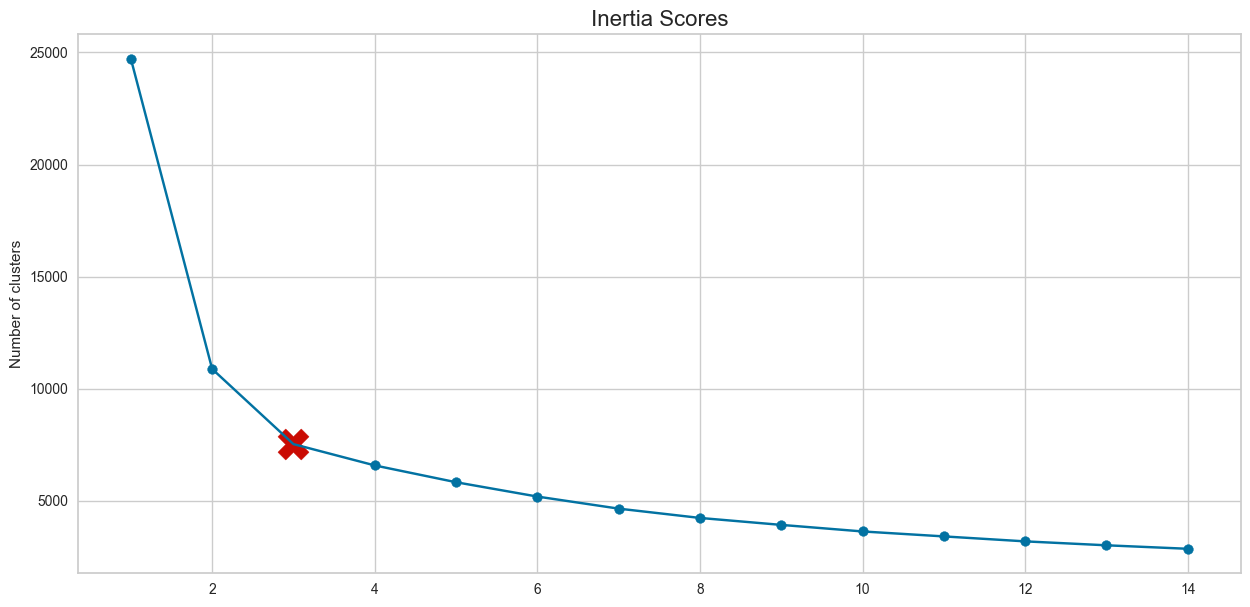

In [58]:
plt.figure(figsize=(15,7))
plt.plot(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.scatter(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.scatter(3, list(scores_kmeans.values())[2], marker="X", s=500, c="r")
plt.title('Inertia Scores', fontsize=16)
plt.ylabel('Number of clusters')
plt.show()

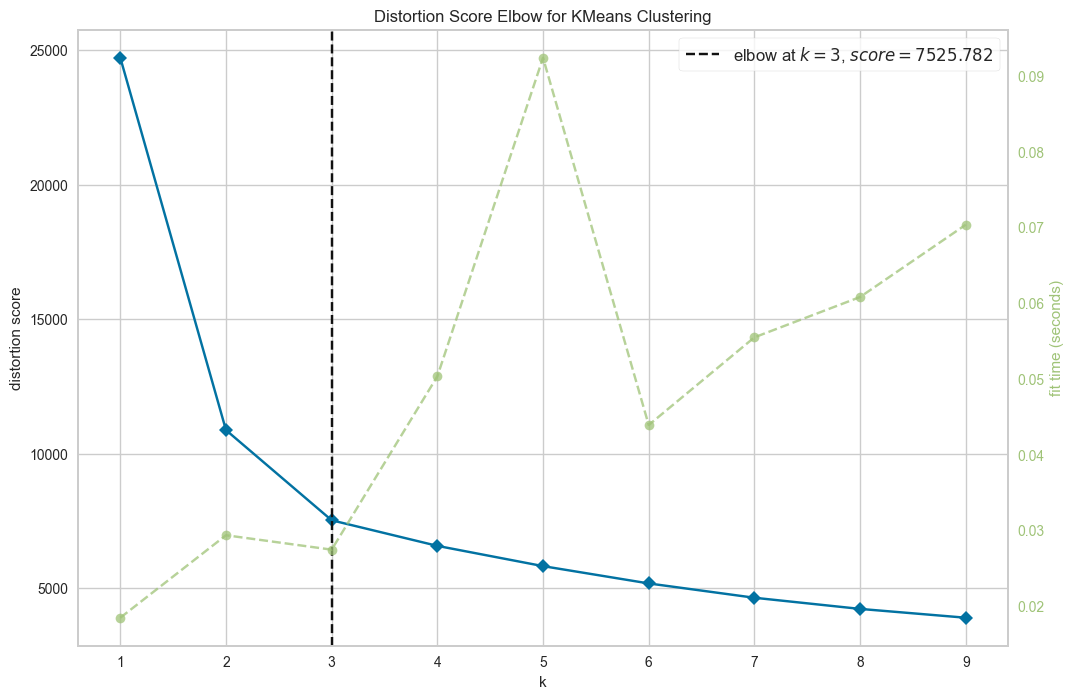

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
# Use the elbow method to determine the number of cluster

# Build the model with the best number of cluster based on the Elbow Method 
kmeans = KMeans()

# Use KElbowVisualizer to visualize the Elbow plot for K value in range of (1,15)
visualizer = KElbowVisualizer(kmeans, k=(1,10))

# Fit the data to the visualizer
plt.figure(figsize=(12,8))
visualizer.fit(X)
visualizer.show()

According to the elbow method the best number of clusters is 3.

Based on the results obtained with the Elbow Method. I picked three number of clusters (2,3,4) to explore the results using the Silhouette method.

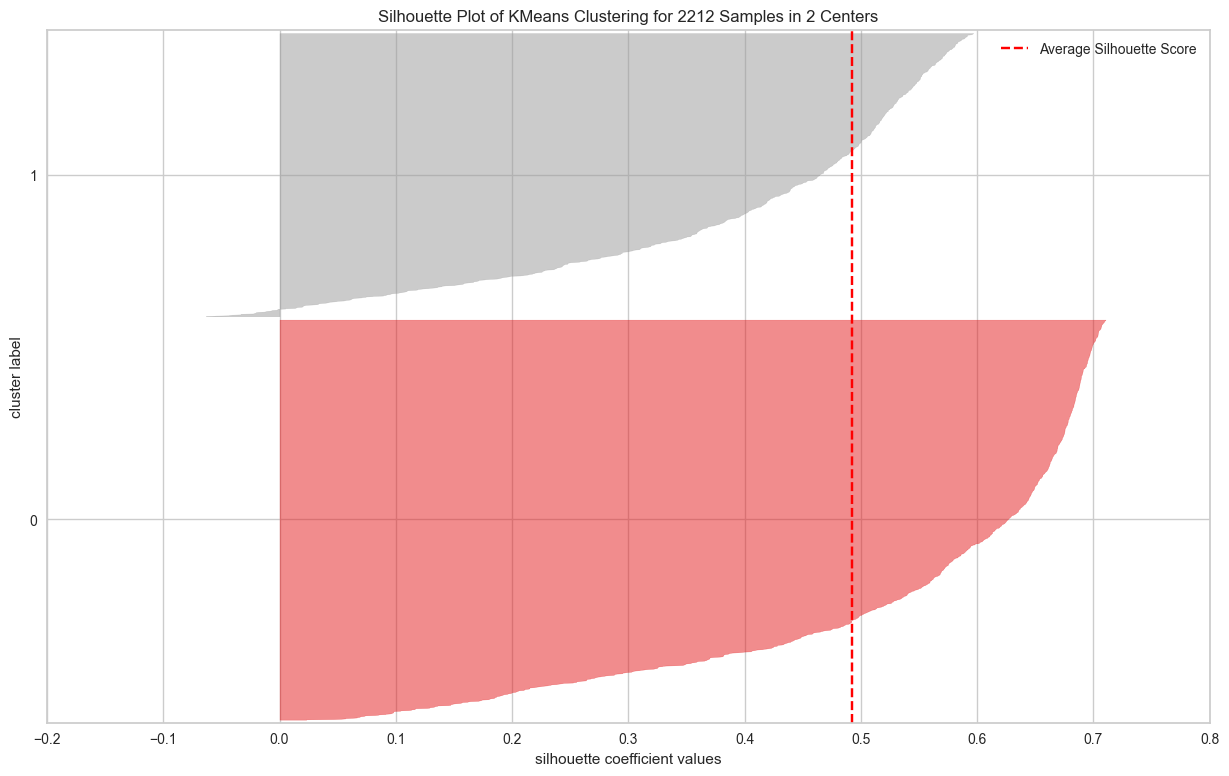

The silhouette coefficient for 2 clusters is 0.4925995952644735


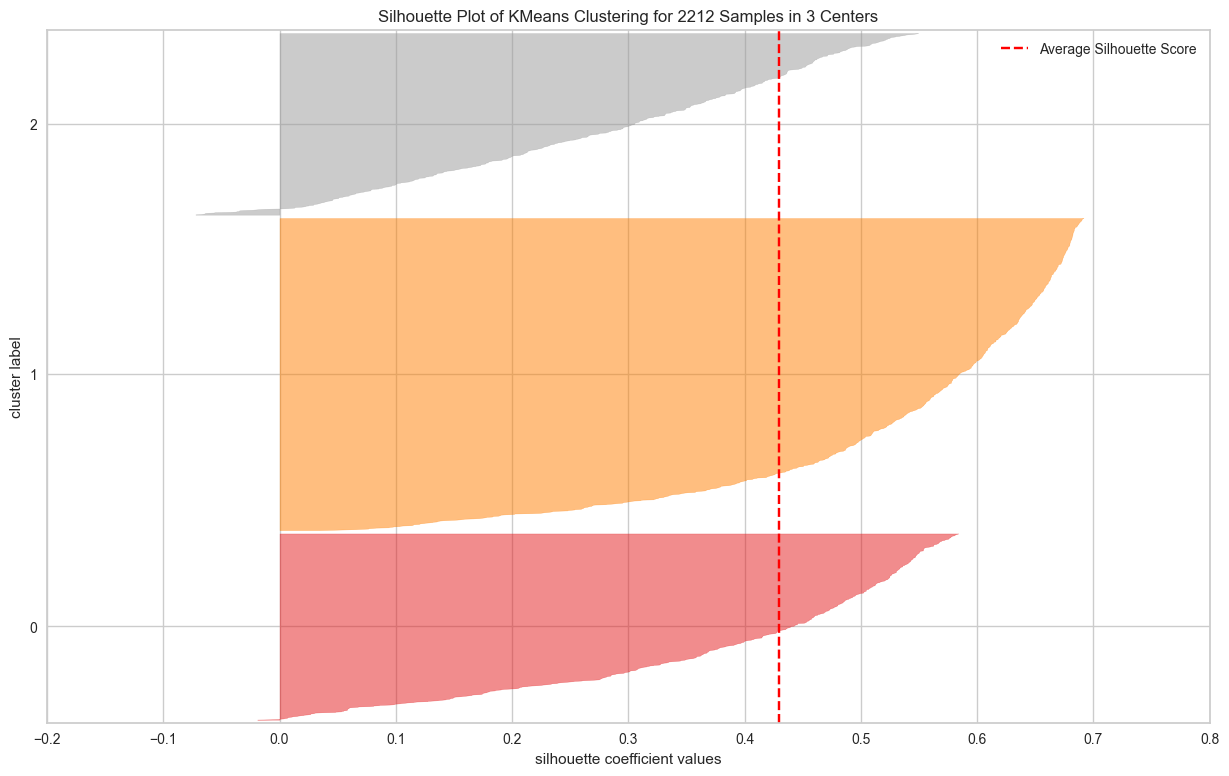

The silhouette coefficient for 3 clusters is 0.42949349833174566


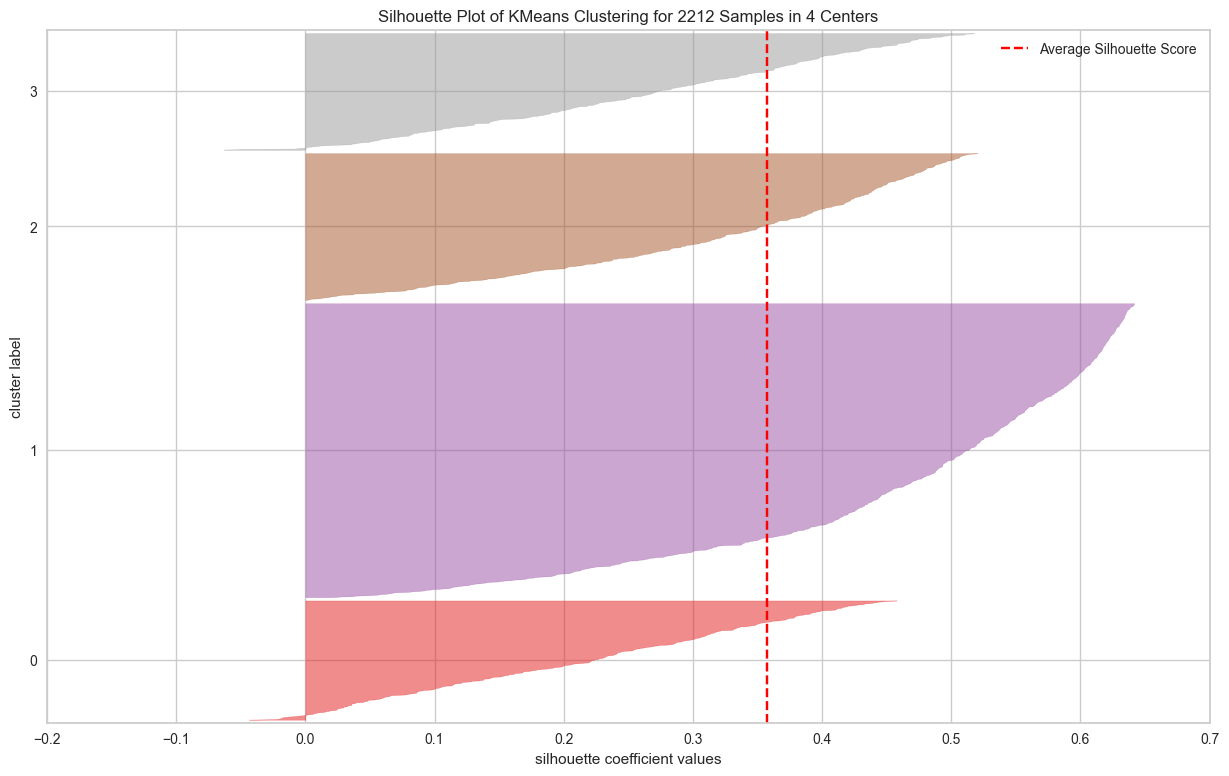

The silhouette coefficient for 4 clusters is 0.35718638820367354


In [89]:
clusters_number=[2,3,4]
#clusters_number=[3]

# Create a loop to generate the plots for the different number of clusters

for cluster in clusters_number:
    # Define the model
    kmeans = KMeans(cluster)
    
    # Use SilhouetteVisualizer to visualize the Silhouette plot for numbers of clusters 2, 3, 4 and 5
    visualizer =SilhouetteVisualizer(kmeans)
    
    # Fit the data to the visualizer
    plt.figure(figsize=(15,9))
    visualizer.fit(X)
    labels=visualizer.labels_
    visualizer.show()
    
    # Obtain the silhouette course using euclidean distance
    sh_score= metrics.silhouette_score(X, labels, metric = 'euclidean')
    print('The silhouette coefficient for {} clusters is {}'.format(cluster, sh_score))

According to the silhouette coeffiecient the best number of cluster is 2 with the higher score.

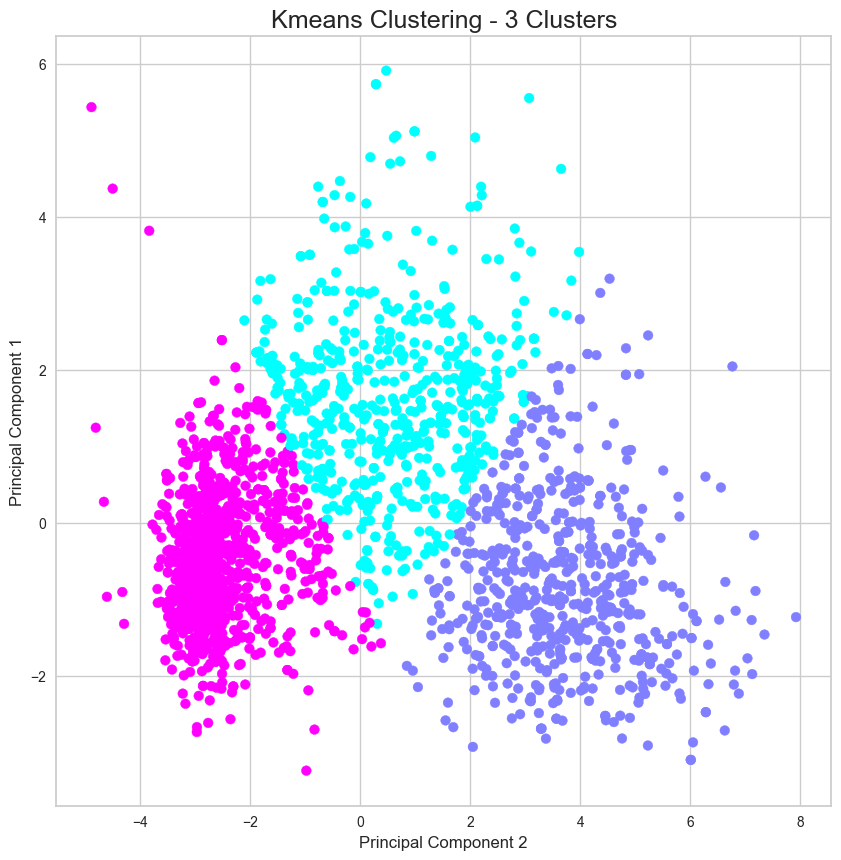

In [61]:
# Use Kmeans with 3 clusters - Elbow Method

kmeans = KMeans(n_clusters=3, random_state=42)
fit= kmeans.fit(X)
labels_Kmeans=fit.labels_

# Plot the results
plt.figure(figsize=(10,10))
plt.scatter(PCA_df['C1'], PCA_df['C2'], c=labels_Kmeans, cmap='cool')
plt.title('Kmeans Clustering - 3 Clusters', fontsize=18)
plt.ylabel('Principal Component 1', fontsize=12)
plt.xlabel('Principal Component 2', fontsize=12)
plt.show()

The cluster on the right includes a section that could represent another cluster. In my opinion the best cluster number for the data is 3

_________

In [62]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

In [63]:
PCA_df

,C1,C2,C3,Clusters
0,4.3316,0.2458,1.0074,0
1,-2.7680,-0.1791,-1.3270,1
2,2.0062,-0.0424,0.0699,0
3,-2.7139,-0.7109,0.2588,1
4,-0.0125,0.8051,0.7248,1
...,...,...,...,...
2207,2.7187,0.8868,1.2271,0
2208,-0.6822,4.1952,-1.2208,0
2209,1.9093,-0.5515,-0.6580,0
2210,2.0780,0.6895,-0.4784,0


In [64]:
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_Spend,Dependents,Total_Accepted,Total_Purchases,Age,Clusters
0,0,1,"58,138.0000",58,635,88,546,172,88,88,...,8,10,4,7,1617,0,0,25,65,0
1,0,1,"46,344.0000",38,11,1,6,2,1,6,...,1,1,2,5,27,2,0,6,68,1
2,0,0,"71,613.0000",26,426,49,127,111,21,42,...,8,2,10,4,776,0,0,21,57,0
3,0,0,"26,646.0000",26,11,4,20,10,3,5,...,2,0,4,6,53,1,0,8,38,1
4,0,0,"58,293.0000",94,173,43,118,46,27,15,...,5,3,6,5,422,1,0,19,41,1


In [65]:
df.groupby('Clusters')['Income'].mean()

Clusters
0   60,183.0399
1   35,929.4844
2   78,867.6284
Name: Income, dtype: float64

In [66]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df["C1"]
y =PCA_df["C2"]
z =PCA_df["C3"]

In [67]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

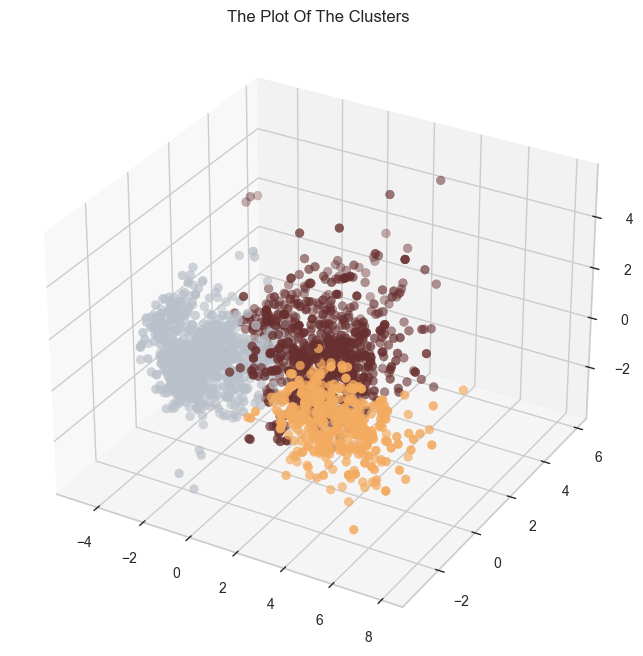

In [68]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap=cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()


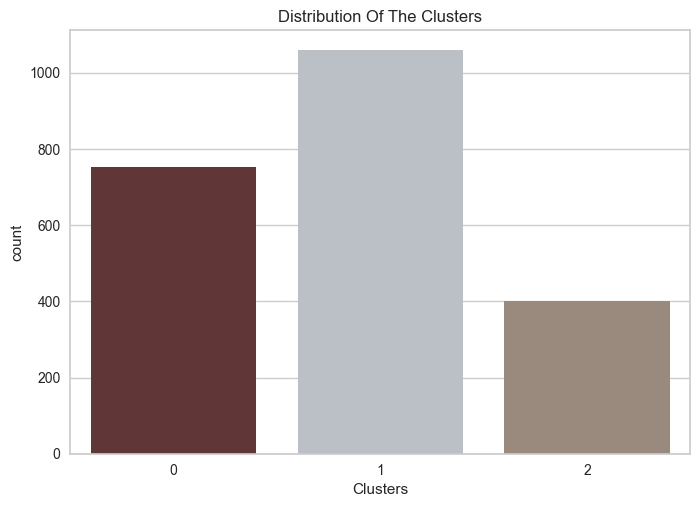

In [69]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [70]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Total_Spend', 'Dependents', 'Total_Accepted', 'Total_Purchases', 'Age',
       'Clusters'],
      dtype='object')

/var/folders/13/lwm1vcb93318m742brcmvqvm0000gn/T/ipykernel_84716/50374723.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  pl = sns.scatterplot(data = data,x=df["Total_Spend"], y=data["Income"],hue=df["Clusters"], palette= pal)


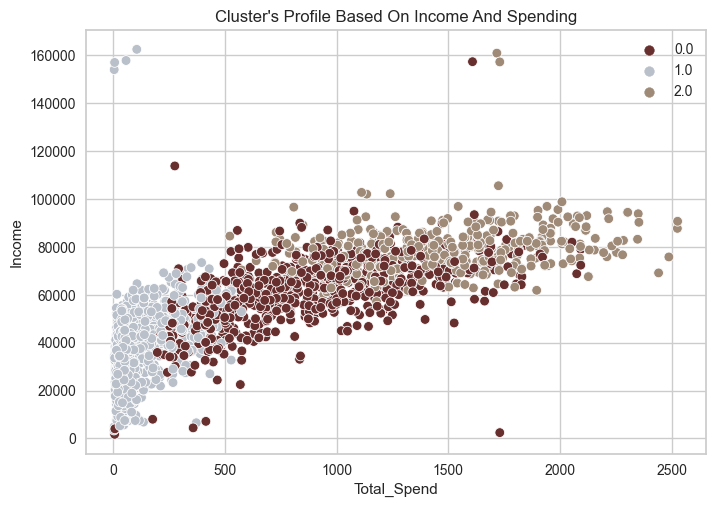

In [71]:
#Plotting countplot of clusters
pl = sns.scatterplot(data = data,x=df["Total_Spend"], y=data["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [72]:
# Average income by cluster
df.groupby('Clusters')['Income'].mean()

Clusters
0   60,183.0399
1   35,929.4844
2   78,867.6284
Name: Income, dtype: float64

In [73]:
# General income average of the customers
df['Income'].mean()

51958.81057866185

In [74]:
# Average spend by cluster
df.groupby('Clusters')['Total_Spend'].mean()

Clusters
0     845.2141
1     111.4703
2   1,470.3965
Name: Total_Spend, dtype: float64

In [75]:
# General Spent verage of the customers
df['Total_Spend'].mean()

607.2680831826401

/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 76.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  w

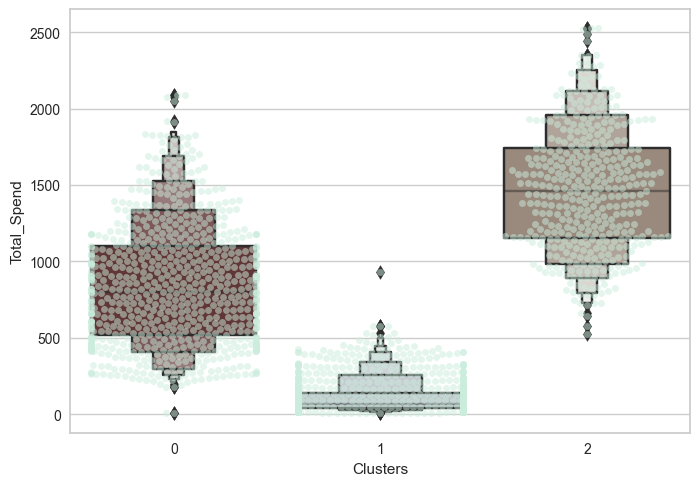

In [76]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Total_Spend"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Total_Spend"], palette=pal)
plt.show()

In [77]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Total_Spend', 'Dependents', 'Total_Accepted', 'Total_Purchases', 'Age',
       'Clusters'],
      dtype='object')

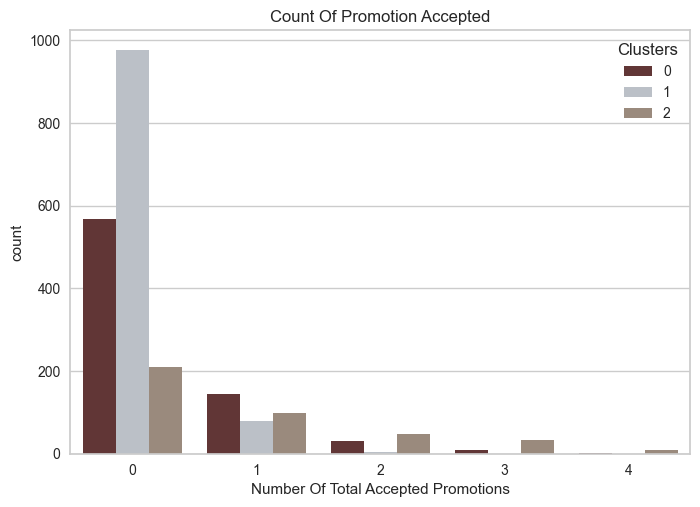

In [78]:
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Accepted"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

In [79]:
# Average spend by cluster
df.groupby('Clusters')['Total_Accepted'].mean()

Clusters
0   0.3165
1   0.0812
2   0.8379
Name: Total_Accepted, dtype: float64

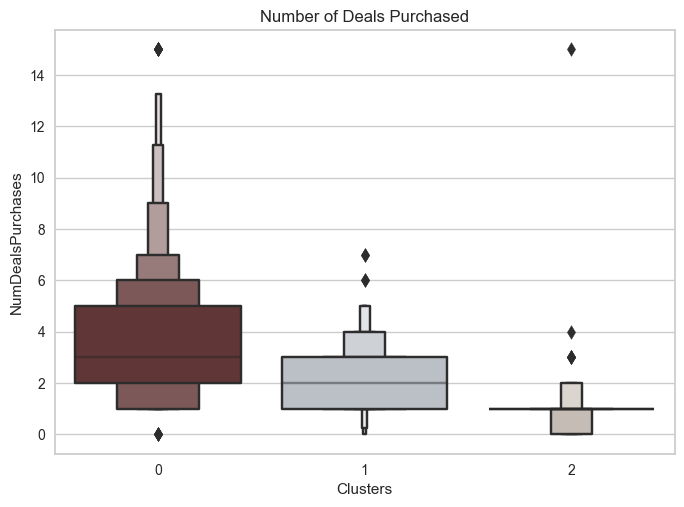

In [80]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

In [81]:
df.groupby('Clusters')['NumDealsPurchases'].mean()

Clusters
0   3.6011
1   1.9122
2   1.0200
Name: NumDealsPurchases, dtype: float64

In [82]:
# Total purchases by shopping method
shopping_method = df.groupby('Clusters')['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'].sum()
shopping_method

/var/folders/13/lwm1vcb93318m742brcmvqvm0000gn/T/ipykernel_84716/3843146257.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  shopping_method = df.groupby('Clusters')['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'].sum()


,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
Clusters,,,
0,4873,2733,5957
1,2327,645,3595
2,1843,2533,3292


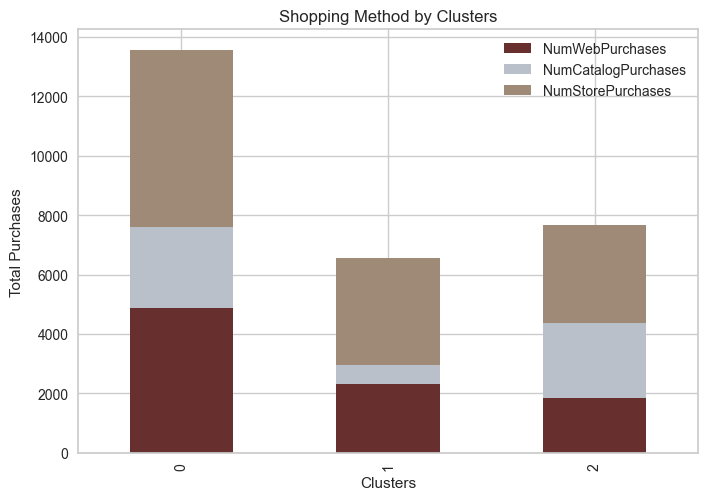

In [83]:
shopping_method.plot(kind='bar', stacked=True, color=pal)
plt.title('Shopping Method by Clusters')
plt.ylabel('Total Purchases')
plt.show()


In [84]:
# Total purchases by product type
total_by_product = df.groupby('Clusters')['MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds'].sum()
total_by_product

/var/folders/13/lwm1vcb93318m742brcmvqvm0000gn/T/ipykernel_84716/837793156.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_by_product = df.groupby('Clusters')['MntWines',


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Clusters,,,,,,
0,368075,23865,135664,33336,24819,49842
1,52896,6124,26720,8691,5953,17663
2,254325,28252,207086,41252,29055,29659


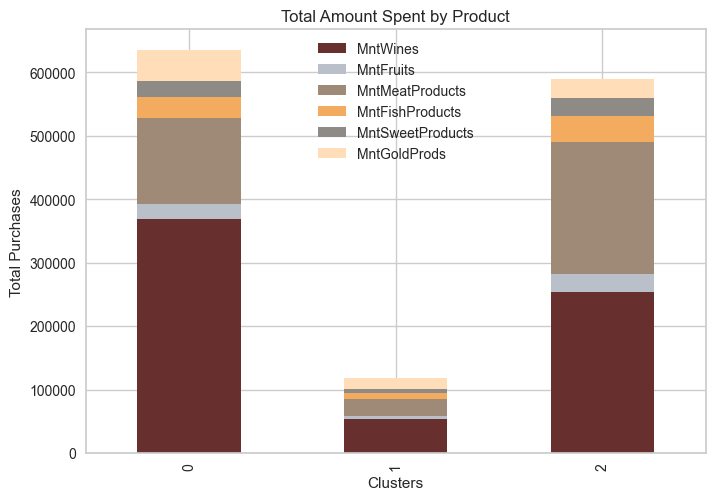

In [85]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60", "#8e8b87", "#ffddb9"]
total_by_product.plot(kind='bar', stacked=True, color=pal)
plt.title('Total Amount Spent by Product')
plt.ylabel('Total Purchases')
plt.show()

In [86]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Total_Spend', 'Dependents', 'Total_Accepted', 'Total_Purchases', 'Age',
       'Clusters'],
      dtype='object')

/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

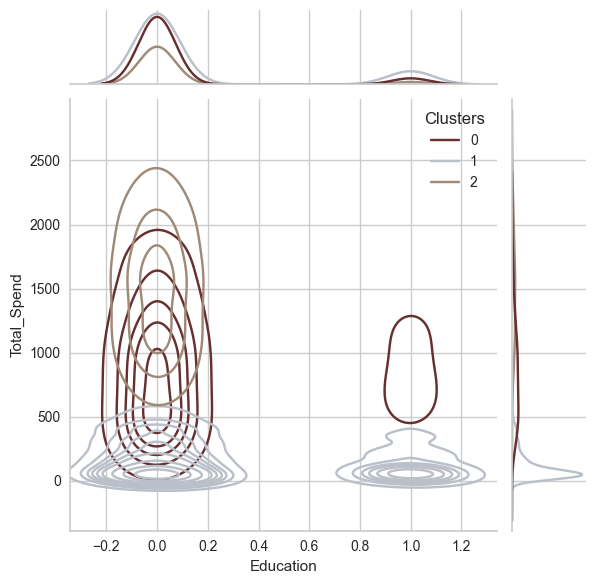

/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

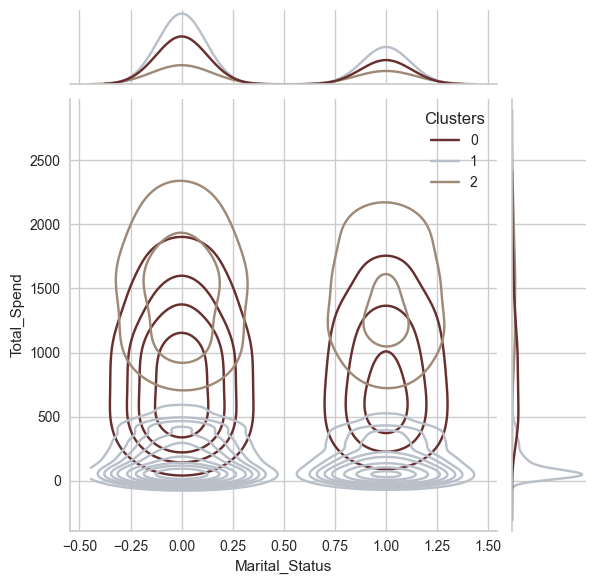

/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

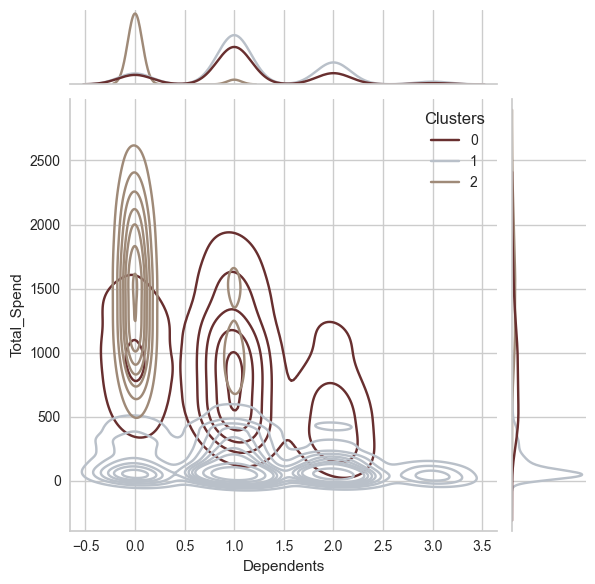

/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/manuelamunoz/miniforge3/envs/DS-env-3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


<Figure size 800x550 with 0 Axes>

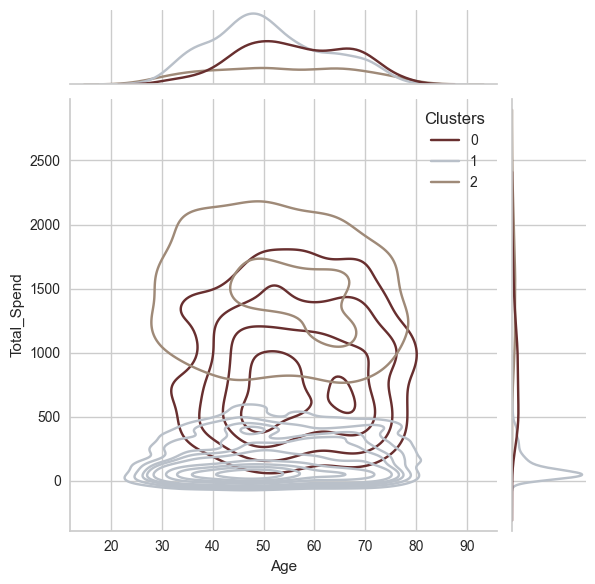

In [87]:
personal = ["Education", "Marital_Status", "Dependents", "Age"]

for i in personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Total_Spend"], hue =df["Clusters"], kind="kde", palette=pal)
    plt.show()

In [88]:
filter = df[(df.Clusters ==2)]
print(filter.corr()['Age'])
print(filter['Age'].mean())
print(filter['Age'].min())
print(filter['Age'].max())

Education              0.0479
Marital_Status        -0.0761
Income                -0.0233
Recency                0.0664
MntWines               0.0117
MntFruits             -0.0624
MntMeatProducts       -0.0871
MntFishProducts        0.0498
MntSweetProducts      -0.0065
MntGoldProds          -0.0308
NumDealsPurchases     -0.0308
NumWebPurchases        0.0316
NumCatalogPurchases    0.0387
NumStorePurchases     -0.0636
NumWebVisitsMonth     -0.0312
Total_Spend           -0.0471
Dependents             0.0393
Total_Accepted        -0.0336
Total_Purchases       -0.0109
Age                    1.0000
Clusters                  NaN
Name: Age, dtype: float64
53.16957605985037
27
81
